In [1]:
from time import time
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from file_utils import read_from_pickle

## Change log


## Loading fitting data

In [2]:
MODEL_DIR = './models/vaccination_tweets'
TRAINING_SIZE_PCT = 'full'
X_train = read_from_pickle('{}/train-{}.pkl'.format(MODEL_DIR, TRAINING_SIZE_PCT))
print(len(X_train))

10920


## Hyper-parameters selection

In [3]:
RANDOM_STATE = 42
models = {
    'kmeans': {
        'model': KMeans(),
        'param_grid': {
            'n_clusters': [2, 4, 8, 12], # , 16, 20
            'n_init': [1],
            'tol': [5e-6, 1e-5, 1e-4], # , 5e-4
            'algorithm': ['lloyd', 'elkan'],
            'random_state': [RANDOM_STATE]
        }
    }
}

def scoring_function(model, x):
    x_ = x
    labels = model.labels_
    if len(x) != len(model.labels_): # fix an issue with GridSearchCV
        print('WARN: adjusting sample size to label length')
        n_samples = min(len(x), len(model.labels_))
        x_ = x[:n_samples]
        labels = model.labels_[:n_samples]
        
    return silhouette_score(x_, labels, metric='euclidean', random_state=RANDOM_STATE)

best_params = None

for model_name in models:
    model = models[model_name]['model']
    param_grid = models[model_name]['param_grid']
    
    start_time = time()
    grid_search = GridSearchCV(model, param_grid, cv=2, scoring=scoring_function, verbose=1)
    grid_search.fit(X_train)
    duration = time() - start_time

    best_params = grid_search.best_params_
    del best_params['n_clusters']
    
    print(model_name, grid_search.best_params_, grid_search.best_score_)

Fitting 2 folds for each of 24 candidates, totalling 48 fits
kmeans {'algorithm': 'lloyd', 'n_init': 1, 'random_state': 42, 'tol': 5e-06} 0.0002974139145083444


## Optimal cluster number selection

In [4]:
cluster_selection = {
    'n_clusters': [],
    'n_iter': [],
    'inertia': [],
    'silhouette_score': []
}

for n_clusters in range(2, 10):
    kmeans = KMeans(n_clusters=n_clusters, **best_params)
    kmeans.fit(X_train)

    score = silhouette_score(X_train, kmeans.labels_, metric='euclidean')
    cluster_selection['n_clusters'].append(n_clusters)
    cluster_selection['n_iter'].append(kmeans.n_iter_)
    cluster_selection['inertia'].append(kmeans.inertia_)
    cluster_selection['silhouette_score'].append(score)
    print('n_clusters {} iters: {} score: {:.4f}'.format(n_clusters, kmeans.n_iter_, score))

n_clusters 2 iters: 21 score: 0.0062
n_clusters 3 iters: 10 score: 0.0093
n_clusters 4 iters: 14 score: 0.0093
n_clusters 5 iters: 19 score: 0.0110
n_clusters 6 iters: 14 score: 0.0119
n_clusters 7 iters: 20 score: 0.0122
n_clusters 8 iters: 30 score: 0.0129
n_clusters 9 iters: 31 score: 0.0133


In [5]:
def optimal_k_plot(clusters, scores, optimal_k=None):
    plt.plot(clusters, scores, marker='o', scalex=False)
    if optimal_k:
        ymin, ymax = min(scores), max(scores)
        plt.vlines(x=optimal_k, ymin=ymin, ymax=ymax, colors='palegreen')
        plt.text(x=optimal_k, y=ymax, s='optimal K={}'.format(optimal_k))
    return plt

### Elbow method

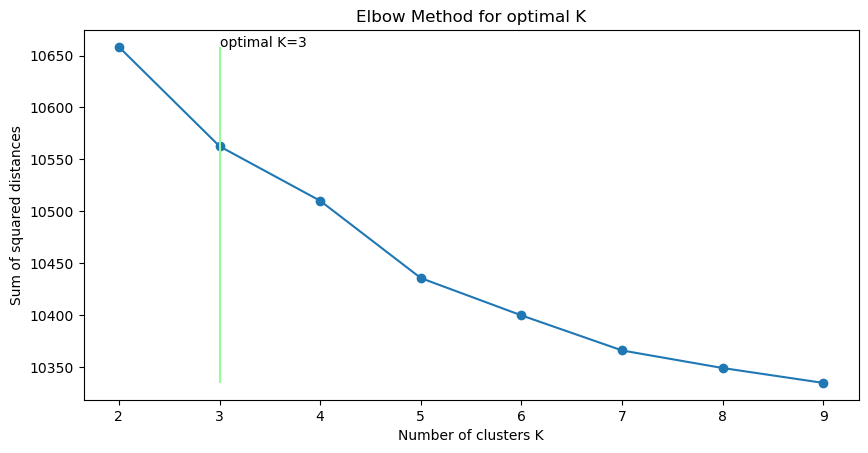

In [8]:
plt.figure().set_figwidth(10)
optimal_k_plot(cluster_selection['n_clusters'], cluster_selection['inertia'], 3)
plt.xlabel('Number of clusters K')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method for optimal K')
plt.show()

### Silhouette method

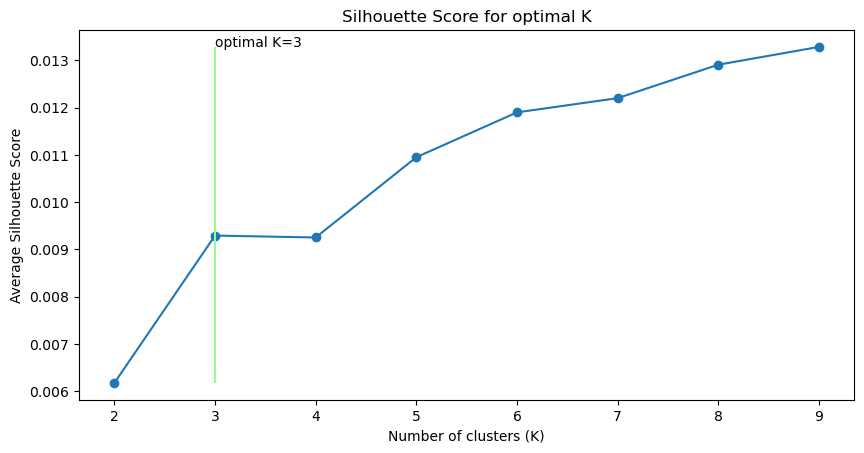

In [9]:
plt.figure().set_figwidth(10)
optimal_k_plot(cluster_selection['n_clusters'], cluster_selection['silhouette_score'], 3)
plt.xlabel('Number of clusters (K)')
plt.ylabel('Average Silhouette Score')
plt.title('Silhouette Score for optimal K')
plt.show()